In [4]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt


# path to the parent directory and add it to the system path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from models.inverted_pendulum import InvertedPendulum

In [5]:
model_parameters = {"mass_cart": 0.5, "mass_pendulum": 0.3, "length": 1.0, "d_c": 0.25, "d_p": 0.012, "gravity": 9.81}
pendulum_model = InvertedPendulum(**model_parameters)
print(pendulum_model)

Parameters of Inverted Pendulum:

    Mass of the cart (kg) -> 0.5
    Mass of the pendulum (kg) -> 0.3
    Length of the pendulum (m) -> 1.0
    Gravitational acceleration (m/s^2) -> 9.81
    Friction coefficient of the cart -> 0.25
    Damping coefficient of the pendulum -> 0.012


In [17]:
pendulum_model.print_symbolic_model()

Nonlinear model of Inverted Pendulum: 

S matrix: 
⎡                l⋅mp⋅cos(θ(t))⎤
⎢   mc + mp      ──────────────⎥
⎢                      2       ⎥
⎢                              ⎥
⎢                       2      ⎥
⎢l⋅mp⋅cos(θ(t))        l ⋅mp   ⎥
⎢──────────────    I + ─────   ⎥
⎣      2                 4     ⎦

L matrix: 
⎡                    d        ⎤
⎢    -l⋅mp⋅sin(θ(t))⋅──(θ(t)) ⎥
⎢                    dt       ⎥
⎢δₓ  ─────────────────────────⎥
⎢                2            ⎥
⎢                             ⎥
⎣0            δₜₕₑₜₐ          ⎦

M matrix: 
⎡        0         ⎤
⎢                  ⎥
⎢-g⋅l⋅mp⋅sin(θ(t)) ⎥
⎢──────────────────⎥
⎣        2         ⎦

N matrix: 
⎡1⎤
⎢ ⎥
⎣0⎦

State vector: 
⎡  x(t)  ⎤
⎢        ⎥
⎢  θ(t)  ⎥
⎢        ⎥
⎢d       ⎥
⎢──(x(t))⎥
⎢dt      ⎥
⎢        ⎥
⎢d       ⎥
⎢──(θ(t))⎥
⎣dt      ⎦

Input variable: 
Fx(t)


In [7]:
A,B = pendulum_model.linearize()
# lQR weight matrices
Q = np.diag([1000, 10, 10, 10])  # State cost
R = np.array([[1]])  # Control cost

In [8]:
C = np.eye(4)
D = np.zeros(B.shape)

from control import matlab
dt = 0.01
sys = matlab.ss(A,B,C,D)
disc = matlab.c2d(sys,dt)
Ad,Bd = disc.A, disc.B
print(disc.A)

[[ 1.00000000e+00 -1.91599081e-04  9.97828382e-03  9.08220879e-07]
 [ 0.00000000e+00  1.00102284e+00  3.25402191e-05  9.99506664e-03]
 [ 0.00000000e+00 -3.82880376e-02  9.95660039e-01  1.17576044e-04]
 [ 0.00000000e+00  2.04504077e-01  6.50262845e-03  9.99354671e-01]]


In [11]:
from controllers.lqr_c import LQRController
lqr_controller = LQRController(Ad,Bd,Q,R, mode='discrete')

In [12]:
initial_state = np.array([0, 0.5, 0, 0])

time_points, states = pendulum_model.simulate(initial_state=initial_state, duration=20, control_func = lqr_controller.compute_control, dt = dt)

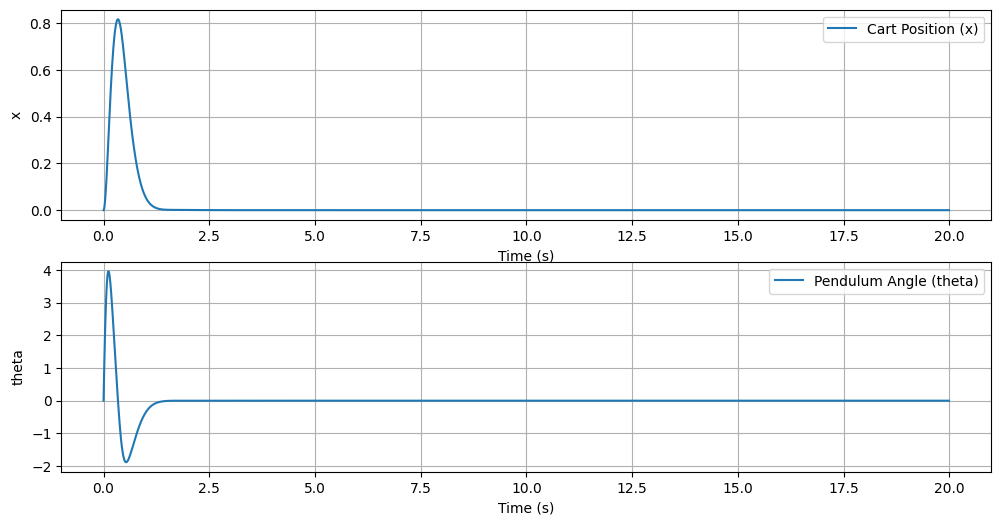

In [13]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_points, states[:, 0], label='Cart Position (x)')
plt.legend()
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("x")

plt.subplot(2, 1, 2)
plt.plot(time_points, states[:, 2], label='Pendulum Angle (theta)')
plt.xlabel("Time (s)")
plt.ylabel("theta")
plt.legend()
plt.grid()
plt.show()